In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#create an engine to connect to the sql database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Verify/check/display the table station
data_station = pd.read_sql("SELECT * FROM station", conn)
data_station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Verify/check/display the table measurement
data_measurement = pd.read_sql("SELECT * FROM measurement", conn)
data_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Calculate the date 1 year ago from the last data point in the database in two steps
# Step 1: Last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date[0]

'2017-08-23'

In [14]:
# Calculate the date 1 year ago from the last data point in the database in two steps
# Step 2: Calculate 1 year ago from the last date
previous_year = '2016-08-23'
previous_year

'2016-08-23'

In [15]:
# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > previous_year)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip[:],columns = ['date','precipitation'])
precip_df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [17]:
# Sort the dataframe by date
precip_df.set_index('date', inplace=True)
precip_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


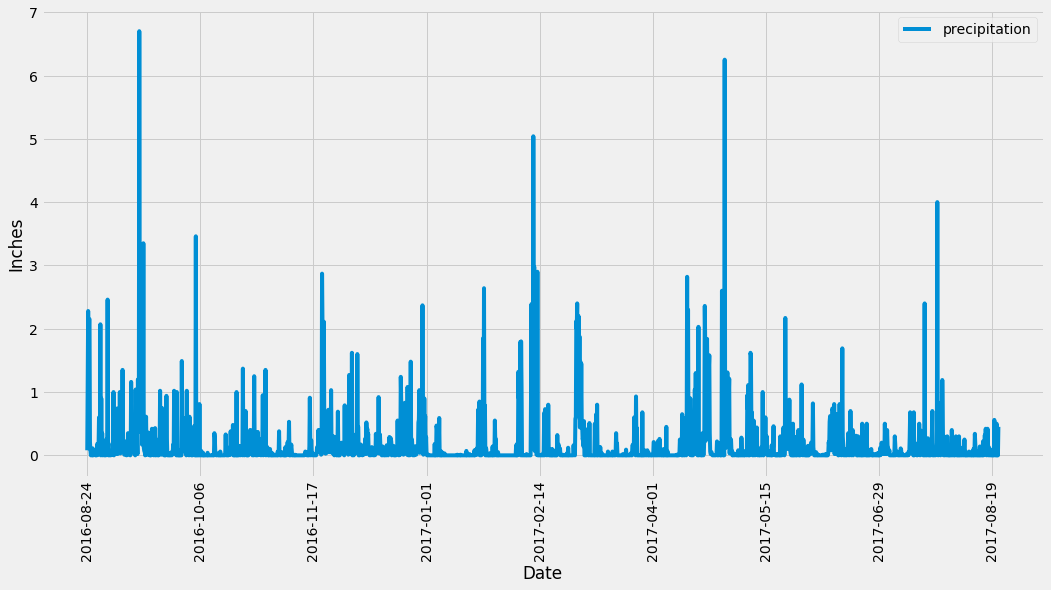

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
#Drop N/A values
precip_df = precip_df.dropna()

#sort by date
precip_df = precip_df.sort_values('date')

plot = precip_df.plot(figsize = (16,8),rot =90)

plot.set_ylabel('Inches')
plot.set_xlabel('Date')
plot.figure.savefig('year_precip.png')

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
active_stations = session.query(Measurement).group_by(Measurement.station).count()
active_stations

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_list = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.
active_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the most active station?
most_active = active_list[0][0]
most_active

'USC00519281'

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded
temp_min = session.query(func.min(Measurement.tobs)).filter_by(station = most_active).all()
temp_min

[(54.0)]

In [24]:
# Using the station id from the previous query, calculate the highest temperature recorded
temp_max = session.query(func.max(Measurement.tobs)).filter_by(station = most_active).all()
temp_max

[(85.0)]

In [25]:
# Using the station id from the previous query, calculate the average temperature of the most
# active station?
temp_avg = session.query(func.avg(Measurement.tobs)).filter_by(station = most_active).all()
temp_avg

[(71.66378066378067)]

In [26]:
# Choose the station with the highest number of temperature observations.
active_temp_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_temp_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Query the last 12 months of temperature observation data for this station
temperature_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > previous_year)
                   .filter(Measurement.station == most_active)
                   .order_by(Measurement.date)
                   .all())

# Convert query to a dataframe
temp_df = pd.DataFrame(temperature_data)
temp_df = temp_df.set_index('date')

# Sort df by date
temp_df = temp_df.sort_index(ascending=True)

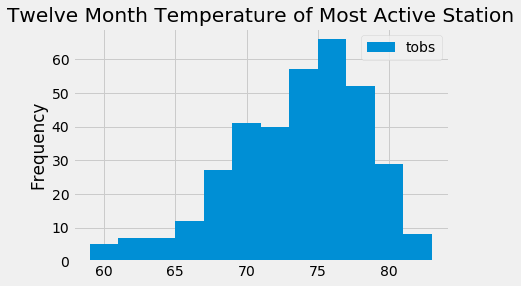

In [28]:
# Plot query results as a histogram
temp_df.plot(kind='hist', bins=12)
plot.set_ylabel('Temperature')
plot.set_xlabel('Frequency')
plt.title("Twelve Month Temperature of Most Active Station")
plot.figure.savefig('year_temp.png')

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [36]:
# Plot the daily normals as an area plot with `stacked=False`
